In [22]:
import tensorflow as tf

In [23]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
from tensorflow import keras

import cv2
from google.colab.patches import cv2_imshow

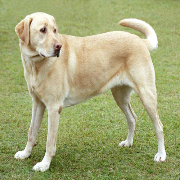

In [24]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

#this is why i need the 'float32' parameters elsewhere
# Normalize an image
def deprocess(img):
  # img = 255*(img + 1.0)/2.0
  img = 255.0*img
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
#original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
original_img= cv2.resize(original_img,(180,180))
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [25]:
#base_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
base_model = keras.models.load_model('/content/drive/My Drive/callbacks/DMT-COLOR-ALLimgs-165e-32_2-64_2-128_3_256_3-256256256-w2dropout-11mparameter.h5')
#base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [26]:
# this gets the layer names to use in the next cell
for layer in base_model.layers:
    print(layer.name)

random_flip
random_rotation
random_zoom
conv2d
conv2d_1
max_pooling2d
conv2d_2
conv2d_3
max_pooling2d_1
conv2d_4
conv2d_5
conv2d_6
max_pooling2d_2
conv2d_7
conv2d_8
conv2d_9
max_pooling2d_3
flatten
dropout
dense
dropout_1
dense_1
dense_2


In [27]:
# Maximize the activations of these layers
#i can make a list of names, compress them and then select specific indexes
#names = ['flatten']
names = [layer.name for layer in base_model.layers]
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [28]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    #loss = tf.math.reduce_variance(act)
    #loss = tf.math.reduce_std(act)
    #loss = act
    losses.append(loss)

  return  tf.reduce_sum(losses)

class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.

        gradients = tape.gradient(loss, img)
        #gradients = #tape.jacobian(loss,img)
        
        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, 0, 1)

      return loss, img

In [29]:
deepdream = DeepDream(dream_model)

In [30]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):

  img = img/255.0
  img = tf.convert_to_tensor(img,dtype='float32')
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  #i can remove tf.constant from here too
  while steps_remaining:
    if steps_remaining>10:
      run_steps = tf.constant(10)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    #removed tf.constant() from step_size
    loss, img = deepdream(img, run_steps, step_size)
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

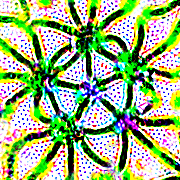

In [32]:
#conv2d78 and conv2d79 make a cool color image
#conv2d83 is butterflies
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=1000, step_size=0.99)


